In [25]:
import alpaca_trade_api as tradeapi
import pandas as pd
import pytz
from datetime import datetime, timedelta
ticker = "GLD"

In [26]:
import alpaca_trade_api as tradeapi

API_KEY = 'PK55SJLN5X7L81OB9D1P'
SECRET_KEY = '3iWrQIdPWUlbNFV1wNcBzGx2JReYbMEQOXtx9rH0'
BASE_URL = 'https://paper-api.alpaca.markets'  # for paper trading

api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# Get your account info
account = api.get_account()
print(account.status)


ACTIVE


In [27]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

start_date_str = '2025-07-07'

# ✅ 修复 RFC3339 格式要求：无微秒、带 Z 时区后缀
end_date_str = datetime.utcnow().replace(microsecond=0).isoformat() + 'Z'

bars = api.get_bars(
    symbol=ticker,
    timeframe='5Min',
    start=start_date_str,
    end=end_date_str,
    feed = 'iex'
).df

# 如果是 MultiIndex
if isinstance(bars.index, pd.MultiIndex):
    bars = bars[bars.index.get_level_values('symbol') == ticker]

print(bars.tail())

                            close     high     low  trade_count    open  \
timestamp                                                                 
2025-07-07 13:45:00+00:00  304.96  305.075  304.95           60  305.03   
2025-07-07 13:50:00+00:00  305.39  305.550  304.97           83  304.97   
2025-07-07 13:55:00+00:00  305.51  305.560  305.32           94  305.40   
2025-07-07 14:00:00+00:00  305.32  305.560  305.24           89  305.56   
2025-07-07 14:05:00+00:00  305.30  305.320  305.28           10  305.32   

                           volume        vwap  
timestamp                                      
2025-07-07 13:45:00+00:00    4883  305.001032  
2025-07-07 13:50:00+00:00    6789  305.328950  
2025-07-07 13:55:00+00:00   11564  305.449334  
2025-07-07 14:00:00+00:00    9235  305.400523  
2025-07-07 14:05:00+00:00     695  305.301667  


In [28]:
# 下载 5 天的 5分钟级数据
data = bars
df = data.reset_index()
print('lastest time')
print(list(df['timestamp'])[-1])

lastest time
2025-07-07 14:05:00+00:00


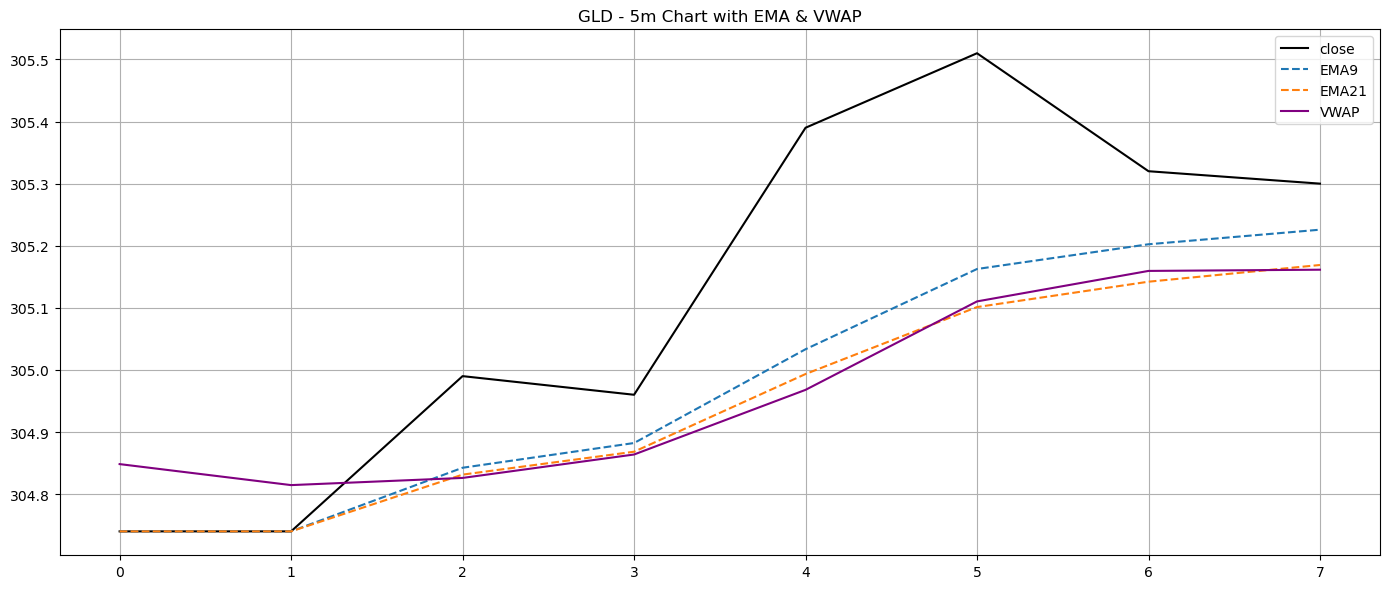

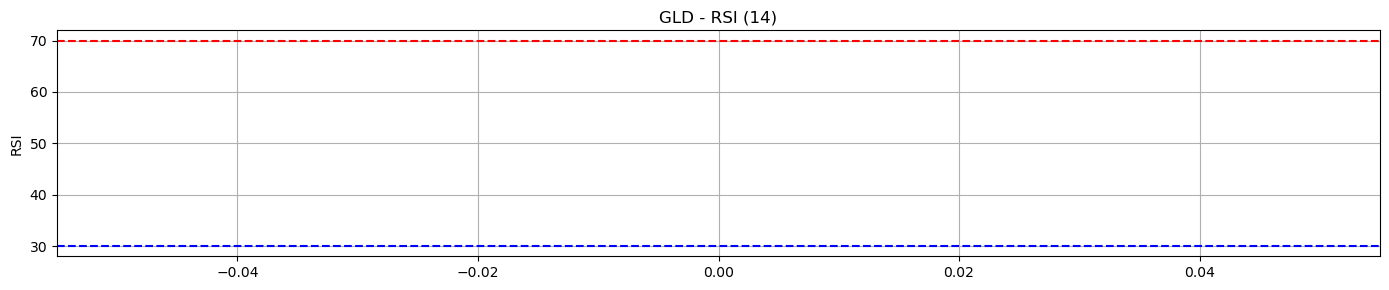

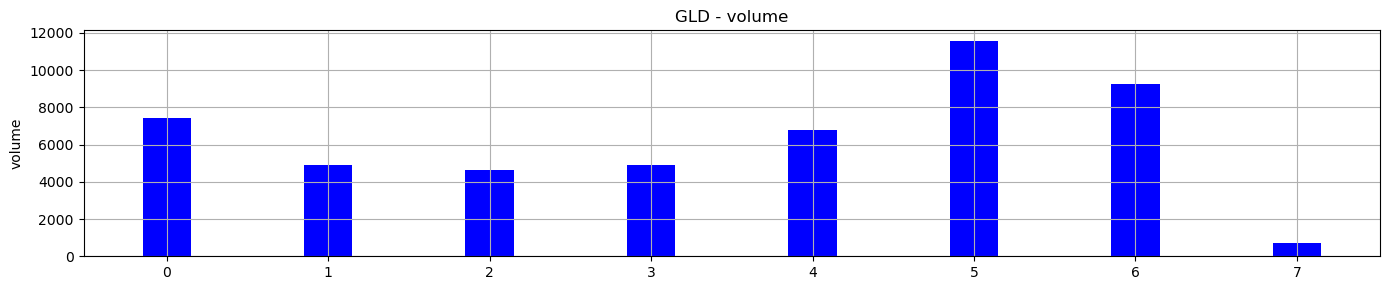

In [29]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 设置股票代码
#ticker = "TQQQ"

# 下载 5 天的 5分钟级数据
# data = yf.download(ticker, interval="5m", period="max")
#df = data.reset_index().droplevel(1, axis=1)
# 计算技术指标
df["EMA9"] = df["close"].ewm(span=9).mean()
df["EMA21"] = df["close"].ewm(span=21).mean()

# RSI
delta = df["close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
df["Typical_Price"] = (df["high"] + df["low"] + df["close"]) / 3
df["Cum_TP_Vol"] = (df["Typical_Price"] * df["volume"]).cumsum()
df["Cum_volume"] = df["volume"].cumsum()
df["VWAP"] = df["Cum_TP_Vol"] / df["Cum_volume"]

# 主图
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.title(f"{ticker} - 5m Chart with EMA & VWAP")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# RSI 图
plt.figure(figsize=(14, 3))
plt.plot(df.index, df["RSI"], label="RSI", color="green")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="blue", linestyle="--")
plt.title(f"{ticker} - RSI (14)")
plt.ylabel("RSI")
plt.grid()
plt.tight_layout()
plt.show()

# volumn plot
plt.figure(figsize=(14, 3))
plt.bar(df.index, df["volume"], width=0.3, color="blue")
plt.title(f"{ticker} - volume")
plt.ylabel("volume")
plt.grid(True)
plt.tight_layout()
plt.show()

## original way

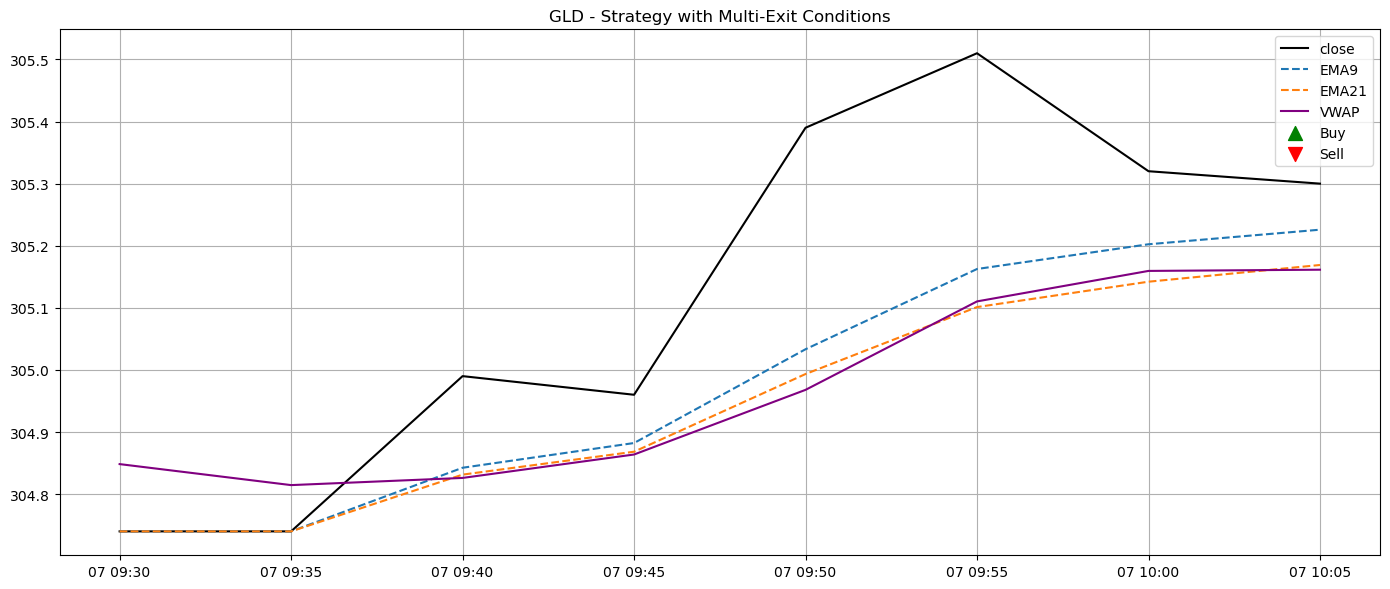

In [30]:
# 买入逻辑
df["Signal"] = 0
df["Up1"] = df["close"].diff(1).shift(1) > 0
df["Up2"] = df["close"].diff(2).shift(1) > 0
df["VolUp"] =  df["volume"].shift(1) > df["volume"].shift(2) # df["volume"].shift(0) > df["volume"].shift(1) #

df.loc[
    (df["EMA9"] > df["EMA21"]) &
    (df["EMA9"].shift(1) <= df["EMA21"].shift(1)) &
    (df["RSI"].between(50, 70)) &
    (df["Up1"]) & (df["Up2"]) &
    (df["VolUp"]),
    "Signal"
] = 1

# 出场逻辑
df["Sell_Signal"] = 0
holding = False
buy_price = 0
buy_time = None
trades = []
for i in range(len(df)):
    row = df.iloc[i]
    time = row.name

    if row["Signal"] == 1:
        holding = True
        buy_price = row["open"]
        buy_time = time
        buy_datetime = row['timestamp']
    elif holding:
        current_price = row["close"]
        change_pct = (current_price - buy_price) / buy_price
        duration = (time - buy_time) / 60 if buy_time else 0
        vw_delta = (current_price - row["VWAP"]) / row["VWAP"]
        rsi_prev = df["RSI"].iloc[i - 1] if i > 0 else row["RSI"]

        # 止盈条件
        tp1 = change_pct >= 0.015
        tp2 = row["RSI"] > 70 and row["RSI"] < rsi_prev
        tp3 = vw_delta > 0.025
        if tp1 or tp2 or tp3:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['timestamp']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None
            continue

        # 止损条件
        sl_conditions = [
            change_pct <= -0.005,
            row["EMA9"] <= row["EMA21"],
            row["RSI"] <= 50,
            row["close"] < row["VWAP"],
            duration > 15
        ]
        if sum(sl_conditions) >= 2:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['timestamp']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None

    

results = pd.DataFrame(trades)
# if not results.empty:
#     print("🔎 回测总结")
#     print(results)
#     print(f"✅ 总交易次数: {len(results)}")
#     print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
#     print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
#     print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# 提取买卖点
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == -1]

df.index = df['timestamp']
# buy_signals.index = buy_signals['timestamp']
# sell_signals.index = sell_signals['timestamp']
# 设置东部时区
eastern = pytz.timezone('US/Eastern')

# 设置 df 索引为 timestamp，并确保是 DatetimeIndex（带时区）
df.index = pd.to_datetime(df['timestamp'])

# 如果 df.index 没有时区，先设置为 UTC，再转换为 Eastern
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert(eastern)

# 同理处理买卖信号（必须重新设置 timestamp 为索引 + 确保 tz）
buy_signals.index = pd.to_datetime(buy_signals['timestamp'])
sell_signals.index = pd.to_datetime(sell_signals['timestamp'])

if buy_signals.index.tz is None:
    buy_signals.index = buy_signals.index.tz_localize('UTC')
buy_signals.index = buy_signals.index.tz_convert(eastern)

if sell_signals.index.tz is None:
    sell_signals.index = sell_signals.index.tz_localize('UTC')
sell_signals.index = sell_signals.index.tz_convert(eastern)
# 绘图展示
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", label="Sell", s=100)
plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()